# Problem 3 Part d)
## Input all parameters of the question

In [31]:
import numpy as np
from math import pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# PARAMETERS
J0 = 1.0e4               # kg*m^2, propeller polar polar moment of inertia
alpha0 = 0.05            # rad, base motion amplitude
omega = 314.16           # rad/s, base motion frequency
zeta = 0.1               # damping ratio
G = 80e9                 # Pa, shear modulus of steel

# Stepped shaft
L1 = 20.0                # m, length of first step
Do1 = 0.4                # m, outer diameter of first step
Di1 = 0.2                # m, inner diameter of first step

L2 = 30.0                # m, length of second step
Do2 = 0.6                # m, outer diameter of second step
Di2 = 0.4                # m, inner diameter of second step

# Initial conditions
theta0 = 0.0             # rad
thetadot0 = 0.1          # rad/s

# Simulation time window
t_final = 2.0            # seconds
n_points = 4000          # points for plotting

## Define functions for generating equivalent spring stiffness

In [32]:
def polar_second_moment(Do, Di=0.0):
    """Polar second moment for a hollow circular cross-section.
       Jp = (pi/32) * (Do^4 - Di^4)"""
    return (pi/32.0) * (Do**4 - Di**4)

def compute_segment_stiffness(G, Jp, L):
    """Torsional stiffness k = G*Jp / L"""
    return G * Jp / L

def equivalent_series_stiffness(k_list):
    """Equivalent stiffness for torsional elements in series."""
    return 1.0 / sum(1.0/k for k in k_list)

## compute equivalent stiffness and use it to find natural frequency and damping

In [33]:
# Cross-section polar moments
Jp1 = polar_second_moment(Do1, Di1)
Jp2 = polar_second_moment(Do2, Di2)

# Segment stiffnesses
k1 = compute_segment_stiffness(G, Jp1, L1)
k2 = compute_segment_stiffness(G, Jp2, L2)

# Total torsional stiffness (series)
k_total = equivalent_series_stiffness([k1, k2])

# Natural frequency and damping
wn = np.sqrt(k_total / J0)
c_crit = 2.0 * np.sqrt(k_total * J0)
c_t = 2.0 * zeta * np.sqrt(k_total * J0)

## Define the alpha equations and the equation of motion in terms of the alphas (needed for ODE solver)

In [34]:
# Equation: J0*theta_ddot + c_t*(theta_dot - alpha_dot) + k_total*(theta - alpha) = 0
def alpha(t):
    return alpha0 * np.sin(omega * t)
def alpha_dot(t):
    return alpha0 * omega * np.cos(omega * t)

def rhs(t, y):
    theta, thetadot = y
    theta_ddot = (-c_t * (thetadot - alpha_dot(t)) - k_total * (theta - alpha(t))) / J0
    return [thetadot, theta_ddot]

## Define points between 0 and 2s we want to solve the ODE at, then solve ODE using RK45 (same as Matlab)

In [35]:
t_eval = np.linspace(0.0, t_final, n_points)
y0 = [theta0, thetadot0]

sol = solve_ivp(rhs, (0.0, t_final), y0, t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-10)

t = sol.t
theta_t = sol.y[0]
thetadot_t = sol.y[1]

## Plot results, and find peak within the last 10% of the result, to compare with b)

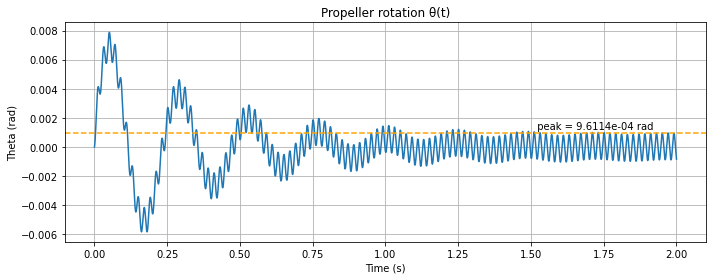

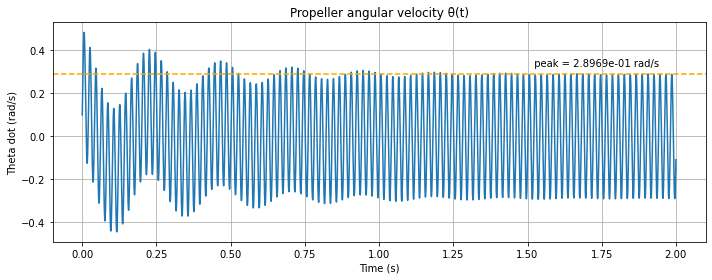

In [49]:
plt.rcParams.update({"figure.figsize": (10,4), "axes.grid": True})

# -------- Peak detection near end (theta) --------
# We take the last 10% of samples to avoid early transients
idx_start_theta = int(0.90 * len(theta_t))
theta_tail = theta_t[idx_start_theta:]

peak_idx_theta = np.argmax(theta_tail)
peak_theta = theta_tail[peak_idx_theta]

# -------- Plot theta(t) --------
plt.figure()
plt.plot(t, theta_t, label='θ(t)')
plt.axhline(peak_theta, linestyle='--', linewidth=1.5, color='orange')
plt.text(t[-1000], peak_theta*1.1, f"  peak = {peak_theta:.4e} rad", va='bottom')

plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Propeller rotation θ(t)')
plt.tight_layout()

# -------- Peak detection near end (thetadot) --------
idx_start_td = int(0.90 * len(thetadot_t))
td_tail = thetadot_t[idx_start_td:]
t_tail2 = t[idx_start_td:]

peak_idx_td = np.argmax(td_tail)
peak_td = td_tail[peak_idx_td]

# -------- Plot thetadot(t) --------
plt.figure()
plt.plot(t, thetadot_t, label='θ̇(t)')
plt.axhline(peak_td, linestyle='--', linewidth=1.5, color='orange')
plt.text(t[-1000], peak_td*1.1, f"  peak = {peak_td:.4e} rad/s", va='bottom')

plt.xlabel('Time (s)')
plt.ylabel('Theta dot (rad/s)')
plt.title('Propeller angular velocity θ̇(t)')
plt.tight_layout()


## Peak theta occured at 9.6114e-4 rad, very similar to the 9.203e-4 I found by hand. The fact its slightly higher implies we haven't made it to steady-state yet
## Peak theta dot occured at 2.8969e-1 rad, very similar to the 2.891e-1 you find by multiplying theta max (9.203e-4) by omega (314.16). The fact its slightly higher implies we haven't made it to steady-state yet